### Build a basic chatbot with langgraph (graph api)

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages



In [3]:
from langchain.schema.messages import AIMessage, HumanMessage

In [4]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
llm=ChatGroq(model="llama-3.1-8b-instant")

In [7]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A9A16435E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A9A1A4EAA0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [75]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [76]:
graph_builder=StateGraph(State)

# Add Nodes
graph_builder.add_node("llmchatbot",chatbot)

# Add Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# Compile Graph
graph=graph_builder.compile()

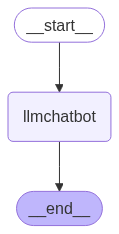

In [77]:
# Visulaize the graph 

from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [81]:
response=graph.invoke({"messages":"Hi"})

In [86]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [93]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm here and ready to help with any questions or tasks you may have. How can I assist you today?


### Chatbot with Tools

In [8]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_result=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [9]:
# Custom function 
def multiply(a:int, b:int) -> int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [10]:
tools=[tool,multiply]

In [11]:
llm_with_tool=llm.bind_tools(tools)

In [12]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A9A16435E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A9A1A4EAA0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

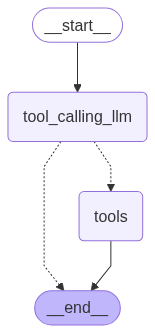

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Define node
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")  # fixed typo
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

# Compile
graph = builder.compile()

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))  # fixed method call

In [14]:
response=graph.invoke({"messages":"What is the recent AI News"})

In [15]:
response['messages'][-1].content

'<function=tavily_search>{"query": "recent AI news", "search_depth": "advanced", "topic": "news"}'

In [16]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI News
================================== Ai Message ==================================

<function=tavily_search>{"query": "recent AI news", "search_depth": "advanced", "topic": "news"}


In [17]:
response=graph.invoke({"messages":"What is 5 multiplie by 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplie by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (sx1tdsbba)
 Call ID: sx1tdsbba
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15


In [18]:
response=graph.invoke({"messages":"Give me the recent AI News then multiply 5 and 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI News then multiply 5 and 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (pxbnexcc7)
 Call ID: pxbnexcc7
  Args:
    exclude_domains: None
    include_domains: None
    include_favicon: True
    include_images: True
    query: latest AI news
    search_depth: advanced
    time_range: day
    topic: news
  multiply (nah8eg42f)
 Call ID: nah8eg42f
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": ["https://www.edge-ai-vision.com/wp-content/uploads/2025/07/bz6Yw_q7WJM.jpg", "https://theaitrack.com/wp-content/uploads/elementor/thumbs/Reading-AI-News-August-2025-Image-generated-by-Midjourney-for-The-AI-Track-r63k3v27utg73k2aic8m1iobkob3b5q70vxdvqda74.jpg", "https://n

### ReAct Agent Architecture

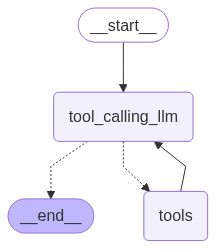

In [19]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Define node
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")  # fixed typo
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

# Compile
graph = builder.compile()

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))  # fixed method call

In [20]:
response=graph.invoke({"messages":"Give me the recent AI News then multiply 5 and 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent AI News then multiply 5 and 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (w432vg7mr)
 Call ID: w432vg7mr
  Args:
    query: AI news
    time_range: day
    topic: news
  multiply (zhjb8g0jz)
 Call ID: zhjb8g0jz
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/elon-musks-xai-shoots-for-the-stars-with-ambitious-dollar200-billion-valuation", "title": "Elon Musk's xAI Shoots for the Stars with Ambitious $200 Billion Valuation - OpenTools", "score": 0.6778372, "published_date": "Sat, 12 Jul 2025 01:08:01 GMT", "content": "Elon Musk's xAI Shoots for the Stars with Ambitious $200 Billion Valuation | AI News Elon Musk's AI ve

### Adding memory in the Agentic Graph

In [ ]:
response=graph.invoke({"messages":"Hello my name is Krish"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

GHello my name is Krish
================================== Ai Message ==================================

Hello Krish, it's nice to meet you. Is there anything I can help you with today?


In [22]:
response=graph.invoke({"messages":"What is my name?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't know your name as I don't have any information about you. I'm happy to chat with you, though!


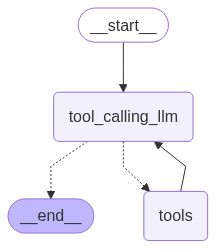

In [23]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

# Define node
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")  # fixed typo
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

# Compile
graph = builder.compile(checkpointer=memory)

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))  # fixed method call

In [24]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Krish"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='6373a11d-ed21-4de8-aeb2-a0e8b873cb52'),
  AIMessage(content="It's nice to meet you Krish. Is there something I can help you with today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1280, 'total_tokens': 1299, 'completion_time': 0.032875896, 'prompt_time': 0.079540484, 'queue_time': 0.05373149600000002, 'total_time': 0.11241638}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'stop', 'logprobs': None}, id='run--052f5787-8cfb-48d5-b02a-f89cfda4857c-0', usage_metadata={'input_tokens': 1280, 'output_tokens': 19, 'total_tokens': 1299})]}

In [25]:
response['messages'][-1].content

"It's nice to meet you Krish. Is there something I can help you with today?"

In [28]:
response=graph.invoke({"messages":"Hey do u remember my name??"},config=config)

response['messages'][-1].content

'Your name is Krish. I remember that from our previous conversation.'

### Streaming

In [29]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [30]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

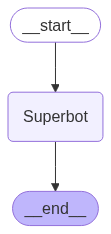

In [31]:
graph=StateGraph(State)

graph.add_node("Superbot",superbot)

graph.add_edge(START,"Superbot")
graph.add_edge("Superbot",END)

graph_builder=graph.compile(checkpointer=memory)

from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [35]:
config={"configurable":{"thread_id":"3"}}

for chunk in graph_builder.stream({"messages":"Hi my name is Ava and I like gaming. My favourite game is CS2."},config=config,stream_mode="updates"):
    print(chunk)


{'Superbot': {'messages': [AIMessage(content="Hello Ava, nice to meet you. CS2, or Counter-Strike 2, is a popular first-person shooter game. It's known for its competitive multiplayer mode and requires a mix of strategy and quick reflexes. What's your role of choice in CS2 - do you prefer playing as an entry fragger, support, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 52, 'total_tokens': 124, 'completion_time': 0.143367444, 'prompt_time': 0.003292574, 'queue_time': 0.049968317, 'total_time': 0.146660018}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--e7e1b588-44d0-4938-a415-92cc28821b62-0', usage_metadata={'input_tokens': 52, 'output_tokens': 72, 'total_tokens': 124})]}}


In [37]:
for chunk in graph_builder.stream({"messages":"Hi my name is Ava and I like gaming. My favourite game is CS2."},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is Ava and I like gaming. My favourite game is CS2.', additional_kwargs={}, response_metadata={}, id='09ee0bb1-acd5-48a9-905b-efcd921047ba'), AIMessage(content="Hello Ava, nice to meet you. CS2, or Counter-Strike 2, is a popular first-person shooter game. It's known for its competitive multiplayer mode and requires a mix of strategy and quick reflexes. What's your role of choice in CS2 - do you prefer playing as an entry fragger, support, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 52, 'total_tokens': 124, 'completion_time': 0.143367444, 'prompt_time': 0.003292574, 'queue_time': 0.049968317, 'total_time': 0.146660018}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'stop', 'logprobs': None}, id='run--e7e1b588-44d0-4938-a415-92cc28821b62-0', usage_metadata={'input_tokens': 52, 'output_tokens': 72, 'total_tokens': 124}),

In [38]:
config={"configurable":{"thread_id":"4"}}

for chunk in graph_builder.stream({"messages":"Hi my name is Ava and I like gaming. My favourite game is CS2."},config=config,stream_mode="updates"):
    print(chunk)


{'Superbot': {'messages': [AIMessage(content="Nice to meet you, Ava. CS2, also known as Counter-Strike 2, is a popular first-person shooter game. It's great that you enjoy playing it. Are you a fan of any particular game mode, such as Bomb Defusal or Competitive? Or do you prefer playing with a specific role, like an entry-fragger or a support player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 52, 'total_tokens': 127, 'completion_time': 0.108893714, 'prompt_time': 0.002621964, 'queue_time': 0.053438516000000005, 'total_time': 0.111515678}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'stop', 'logprobs': None}, id='run--cbd0d0bc-3575-4fe2-a977-de522c941ad8-0', usage_metadata={'input_tokens': 52, 'output_tokens': 75, 'total_tokens': 127})]}}


In [39]:
for chunk in graph_builder.stream({"messages":"Hi my name is Ava and I like gaming. My favourite game is CS2. I alos like football"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is Ava and I like gaming. My favourite game is CS2.', additional_kwargs={}, response_metadata={}, id='d10c8312-f983-4c62-b640-ee5f82c34774'), AIMessage(content="Nice to meet you, Ava. CS2, also known as Counter-Strike 2, is a popular first-person shooter game. It's great that you enjoy playing it. Are you a fan of any particular game mode, such as Bomb Defusal or Competitive? Or do you prefer playing with a specific role, like an entry-fragger or a support player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 52, 'total_tokens': 127, 'completion_time': 0.108893714, 'prompt_time': 0.002621964, 'queue_time': 0.053438516000000005, 'total_time': 0.111515678}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'finish_reason': 'stop', 'logprobs': None}, id='run--cbd0d0bc-3575-4fe2-a977-de522c941ad8-0', usage_metadata={'input_tokens': 52, 'output_tokens': 75, 'total

In [40]:
config={"configurable":{"thread_id":"5"}}

async for chunk in graph_builder.astream_events({"messages":["Hi my name is Ava and I like gaming. My favourite game is CS2."]},config,version="v2"):
    print(chunk)


{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi my name is Ava and I like gaming. My favourite game is CS2.']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '4fea005b-65d8-468d-8346-129dec21fcf6', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is Ava and I like gaming. My favourite game is CS2.', additional_kwargs={}, response_metadata={}, id='e05bc569-8acb-40ed-ad82-b46e20c17218')]}}, 'name': 'Superbot', 'tags': ['graph:step:1'], 'run_id': '4fbfee16-37cb-4f6a-b230-3213520fff67', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'Superbot', 'langgraph_triggers': ('branch:to:Superbot',), 'langgraph_path': ('__pregel_pull', 'Superbot'), 'langgraph_checkpoint_ns': 'Superbot:16885665-1652-d9f1-e29d-b62371b9394f'}, 'parent_ids': ['4fea005b-65d8-468d-8346-129dec21fcf6']}
{'event': 'on_chain_stream', 'run_id': '4fbfee16-37cb-4f6a-b230-3213520fff67', 'name': 'Super